# Multi-Class Image Classification Deep Learning Model for [PROJECT NAME] Using TensorFlow Version 1
### David Lowe
### November 24, 2020

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: This project aims to construct a predictive model using a TensorFlow convolutional neural network (CNN) and document the end-to-end steps using a template. The [PROJECT NAME] dataset is a multi-class classification situation where we attempt to predict one of several (more than two) possible outcomes.

INTRODUCTION: [Sample Paragraph - The Rock Paper Scissors dataset contains images from a variety of different hand poses with different races, ages, and genders. These images have all been generated using CGI techniques as an experiment in determining if a CGI-based dataset can be used for classification against real photos. All of this data is posed against a white background, and each image is 300×300 pixels in 24-bit color.]

ANALYSIS: [Sample Paragraph - The performance of the baseline model achieved an accuracy score of 100% after 15 epochs using the training dataset. After tuning the hyperparameters, the best model processed the validation dataset with an accuracy score of 82.26%. Furthermore, the final model processed the test dataset with an accuracy measurement of 82.26%.]

CONCLUSION: In this iteration, the TensorFlow CNN model appeared to be suitable for modeling this dataset. We should consider experimenting with TensorFlow for further modeling.

Dataset Used: [PROJECT NAME] Dataset

Dataset ML Model: Multi-class image classification with numerical attributes

Dataset Reference: [http://www.laurencemoroney.com/rock-paper-scissors-dataset/]

One potential source of performance benchmarks: [http://www.laurencemoroney.com/rock-paper-scissors-dataset/]

A deep-learning image classification project generally can be broken down into five major tasks:

1. Prepare Environment
2. Load and Prepare Images
3. Define and Train Models
4. Evaluate and Optimize Models
5. Finalize Model and Make Predictions

# Task 1 - Prepare Environment

In [ ]:
# Install the packages to support accessing environment variable and SQL databases
!pip install python-dotenv PyMySQL boto3

     |████████████████████████████████| 51kB 5.7MB/s 
     |████████████████████████████████| 133kB 20.3MB/s 
     |████████████████████████████████| 6.8MB 19.6MB/s 
     |████████████████████████████████| 71kB 9.0MB/s 
     |████████████████████████████████| 143kB 49.7MB/s 
ERROR: requests 2.23.0 has requirement urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you'll have urllib3 1.26.2 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
# Retrieve GPU configuration information from Colab
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Sat Nov 14 05:32:24 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    24W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Retrieve memory configuration information from Colab
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
    print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
    print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
    print('re-execute this cell.')
else:
    print('You are using a high-RAM runtime!')

Your runtime has 13.7 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime → "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


In [ ]:
# # Direct Colab to use TensorFlow v2
# %tensorflow_version 2.x

In [ ]:
# Retrieve CPU information from the system
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 2


## 1.a) Load libraries and modules

In [ ]:
# Set the random seed number for reproducible results
seedNum = 888

In [ ]:
# Load libraries and packages
import random
random.seed(seedNum)
import numpy as np
np.random.seed(seedNum)
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sys
import boto3
import zipfile
from datetime import datetime
from dotenv import load_dotenv
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import tensorflow as tf
tf.random.set_seed(seedNum)
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

/usr/local/lib/python3.6/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.2) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


## 1.b) Set up the controlling parameters and functions

In [ ]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
n_jobs = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set Pandas options
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 140)

# Set the percentage sizes for splitting the dataset
test_set_size = 0.2
val_set_size = 0.25

# Set various default modeling parameters
default_loss = 'categorical_crossentropy'
default_metrics = ['accuracy']
default_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
default_kernel_init = tf.keras.initializers.GlorotUniform(seed=seedNum)
default_epoch = 15
default_batch = 16
default_image_size = (150, 150)
input_image_shape = (150, 150, 3)
num_classes = 3

# Define the labels to use for graphing the data
train_metric = "accuracy"
validation_metric = "val_accuracy"
train_loss = "loss"
validation_loss = "val_loss"

# Check the number of GPUs accessible through TensorFlow
print('Num GPUs Available:', len(tf.config.list_physical_devices('GPU')))

# Print out the TensorFlow version for confirmation
print('TensorFlow version:', tf.__version__)

Num GPUs Available: 1
TensorFlow version: 2.3.0


In [ ]:
# Set up the parent directory location for loading the dotenv files
# useColab = True
# if useColab:
#     # Mount Google Drive locally for storing files
#     from google.colab import drive
#     drive.mount('/content/gdrive')
#     gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
#     env_path = '/content/gdrive/My Drive/Colab Notebooks/'
#     dotenv_path = env_path + "python_script.env"
#     load_dotenv(dotenv_path=dotenv_path)

# Set up the dotenv file for retrieving environment variables
# useLocalPC = True
# if useLocalPC:
#     env_path = "/Users/david/PycharmProjects/"
#     dotenv_path = env_path + "python_script.env"
#     load_dotenv(dotenv_path=dotenv_path)

In [ ]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [ ]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 1 - Prepare Environment has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [ ]:
# Reset the random number generators
def reset_random(x):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [ ]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 1 - Prepare Environment completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 2 - Load and Prepare Images

In [ ]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 2 - Load and Prepare Images has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [ ]:
# Clean up the old files and download directories before receiving new ones
!rm -rf staging/
!rm rps.zip
!rm rps-test-set.zip

rm: cannot remove 'rps.zip': No such file or directory
rm: cannot remove 'rps-test-set.zip': No such file or directory


In [ ]:
!wget https://dainesanalytics.com/datasets/laurencemoroney-rock-paper-scissors-dataset/rps.zip

--2020-11-14 05:32:29--  https://dainesanalytics.com/datasets/laurencemoroney-rock-paper-scissors-dataset/rps.zip
Resolving dainesanalytics.com (dainesanalytics.com)... 65.9.43.58, 65.9.43.95, 65.9.43.8, ...
Connecting to dainesanalytics.com (dainesanalytics.com)|65.9.43.58|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 200682221 (191M) [application/zip]
Saving to: ‘rps.zip’

rps.zip             100%[===================>] 191.38M   105MB/s    in 1.8s    

2020-11-14 05:32:31 (105 MB/s) - ‘rps.zip’ saved [200682221/200682221]



In [ ]:
!wget https://dainesanalytics.com/datasets/laurencemoroney-rock-paper-scissors-dataset/rps-test-set.zip

--2020-11-14 05:32:31--  https://dainesanalytics.com/datasets/laurencemoroney-rock-paper-scissors-dataset/rps-test-set.zip
Resolving dainesanalytics.com (dainesanalytics.com)... 65.9.43.58, 65.9.43.95, 65.9.43.8, ...
Connecting to dainesanalytics.com (dainesanalytics.com)|65.9.43.58|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29516758 (28M) [application/zip]
Saving to: ‘rps-test-set.zip’

rps-test-set.zip    100%[===================>]  28.15M  71.8MB/s    in 0.4s    

2020-11-14 05:32:31 (71.8 MB/s) - ‘rps-test-set.zip’ saved [29516758/29516758]



In [ ]:
staging_dir = 'staging/'
!mkdir staging/

In [ ]:
# Unzip and put the files into the staging folder
local_zip = 'rps.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall(staging_dir)
local_zip = 'rps-test-set.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall(staging_dir)
zip_ref.close()

In [ ]:
training_dir = 'staging/rps/'
validation_dir = 'staging/rps-test-set/'
class1_name = 'rock'
class2_name = 'paper'
class3_name = 'scissors'

In [ ]:
# Brief listing of training image files for class 1
training_class1_dir = os.path.join(training_dir, class1_name)
training_class1_files = os.listdir(training_class1_dir)
print('Number of training images for', class1_name, ':', len(os.listdir(training_class1_dir)))
print('Training samples for', class1_name, ':', training_class1_files[:10])

# Brief listing of training image files for class 2
training_class2_dir = os.path.join(training_dir, class2_name)
training_class2_files = os.listdir(training_class2_dir)
print('Number of training images for', class2_name, ':', len(os.listdir(training_class2_dir)))
print('Training samples for', class2_name, ':', training_class2_files[:10])

# Brief listing of training image files for class 3
training_class3_dir = os.path.join(training_dir, class3_name)
training_class3_files = os.listdir(training_class3_dir)
print('Number of training images for', class3_name, ':', len(os.listdir(training_class3_dir)))
print('Training samples for', class3_name, ':', training_class3_files[:10])

Number of training images for rock : 840
Training samples for rock : ['rock03-108.png', 'rock01-005.png', 'rock01-060.png', 'rock01-050.png', 'rock02-101.png', 'rock05ck01-071.png', 'rock06ck02-027.png', 'rock01-113.png', 'rock07-k03-017.png', 'rock05ck01-036.png']
Number of training images for paper : 840
Training samples for paper : ['paper04-099.png', 'paper06-004.png', 'paper02-021.png', 'paper02-048.png', 'paper04-088.png', 'paper07-084.png', 'paper06-071.png', 'paper06-085.png', 'paper07-047.png', 'paper07-069.png']
Number of training images for scissors : 840
Training samples for scissors : ['testscissors02-032.png', 'scissors02-074.png', 'scissors01-041.png', 'scissors04-117.png', 'scissors01-045.png', 'scissors01-046.png', 'testscissors03-063.png', 'scissors03-003.png', 'scissors02-076.png', 'scissors02-036.png']


In [ ]:
# Brief listing of validation image files for class 1
validation_class1_dir = os.path.join(validation_dir, class1_name)
validation_class1_files = os.listdir(validation_class1_dir)
print('Number of validation images for', class1_name, ':', len(os.listdir(validation_class1_dir)))
print('Validation samples for', class1_name, ':', validation_class1_files[:10])

# Brief listing of validation image files for class 2
validation_class2_dir = os.path.join(validation_dir, class2_name)
validation_class2_files = os.listdir(validation_class2_dir)
print('Number of validation images for', class2_name, ':', len(os.listdir(validation_class2_dir)))
print('Validation samples for', class2_name, ':', validation_class2_files[:10])

# Brief listing of validation image files for class 3
validation_class3_dir = os.path.join(validation_dir, class3_name)
validation_class3_files = os.listdir(validation_class3_dir)
print('Number of validation images for', class3_name, ':', len(os.listdir(validation_class3_dir)))
print('Validation samples for', class3_name, ':', validation_class3_files[:10])

Number of validation images for rock : 124
Validation samples for rock : ['testrock02-19.png', 'testrock04-11.png', 'testrock04-08.png', 'testrock04-00.png', 'testrock04-19.png', 'testrock01-23.png', 'testrock01-29.png', 'testrock01-06.png', 'testrock03-22.png', 'testrock03-07.png']
Number of validation images for paper : 124
Validation samples for paper : ['testpaper04-01.png', 'testpaper01-16.png', 'testpaper04-20.png', 'testpaper04-15.png', 'testpaper03-30.png', 'testpaper04-16.png', 'testpaper01-17.png', 'testpaper04-26.png', 'testpaper02-23.png', 'testpaper04-17.png']
Number of validation images for scissors : 124
Validation samples for scissors : ['testscissors04-24.png', 'testscissors01-10.png', 'testscissors04-13.png', 'testscissors02-10.png', 'testscissors02-20.png', 'testscissors04-16.png', 'testscissors04-29.png', 'testscissors02-23.png', 'testscissors04-09.png', 'testscissors01-03.png']


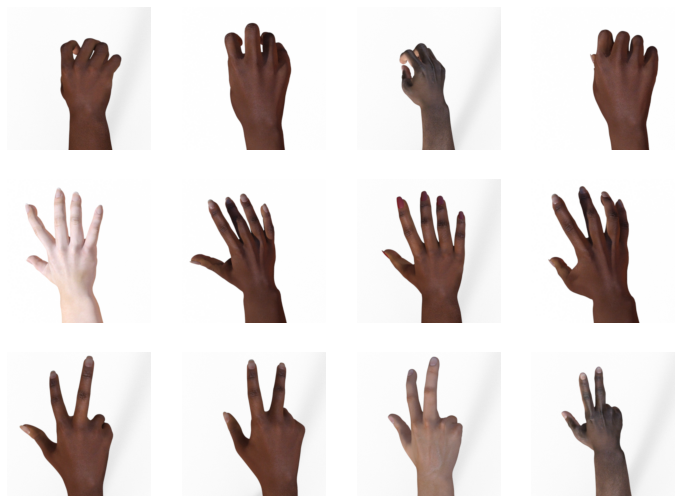

In [ ]:
# Plot some training images from the dataset
nrows = 3
ncols = 4

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 3, nrows * 3)

reset_random(seedNum)
number_elements = ncols
random_training_class1 = random.sample(training_class1_files, number_elements)
random_training_class2 = random.sample(training_class2_files, number_elements)
random_training_class3 = random.sample(training_class3_files, number_elements)
next_class1 = [os.path.join(training_class1_dir, fname) for fname in random_training_class1]
next_class2 = [os.path.join(training_class2_dir, fname) for fname in random_training_class2]
next_class3 = [os.path.join(training_class3_dir, fname) for fname in random_training_class3]

for i, img_path in enumerate(next_class1 + next_class2 + next_class3):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off')
    img = mpimg.imread(img_path)
    plt.imshow(img)
plt.show()

In [ ]:
print('Loading and pre-processing the training images...')
training_datagen = ImageDataGenerator(rescale=1/255)
# training_datagen = ImageDataGenerator(rescale=1./255,
#     featurewise_center=False,  # set input mean to 0 over the dataset
#     samplewise_center=False,  # set each sample mean to 0
#     featurewise_std_normalization=False,  # divide inputs by std of the dataset
#     samplewise_std_normalization=False,  # divide each input by its std
#     zca_whitening=False,  # apply ZCA whitening
#     rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
#     zoom_range = 0.1, # Randomly zoom image 
#     width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
#     height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
#     horizontal_flip=False,  # randomly flip images
#     vertical_flip=False,  # randomly flip images
#     fill_mode='nearest')
training_generator = training_datagen.flow_from_directory(training_dir, target_size=default_image_size, batch_size=default_batch, class_mode='categorical')
print('Number of image batches per epoch of modeling:', len(training_generator))

Loading and pre-processing the training images...
Found 2520 images belonging to 3 classes.
Number of image batches per epoch of modeling: 158


In [ ]:
print('Loading and pre-processing the validation images...')
validation_datagen = ImageDataGenerator(rescale=1/255)
validation_generator = validation_datagen.flow_from_directory(validation_dir, target_size=default_image_size, batch_size=default_batch, class_mode='categorical', shuffle=False)
print('Number of image batches per epoch of modeling:', len(validation_generator))

Loading and pre-processing the validation images...
Found 372 images belonging to 3 classes.
Number of image batches per epoch of modeling: 24


In [ ]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 2 - Load and Prepare Images completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 3 - Define and Train Models

In [ ]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 3 - Define and Train Models has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [ ]:
# Define the function for plotting training results for comparison
def plot_metrics(history):
    fig, axs = plt.subplots(1, 2, figsize=(24, 15))
    metrics =  [train_loss, train_metric]
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color='blue', label='Train')
        plt.plot(history.epoch, history.history['val_'+metric], color='red', linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
#         if metric == train_loss:
#             plt.ylim([0, plt.ylim()[1]])
#         else:
#             plt.ylim([0.5, 1.1])
        plt.legend()

In [ ]:
# Define the baseline model for benchmarking
def create_nn_model(conv1_filters=192, conv2_filters=128, conv3_filters=64, conv1_dropout=0.25, conv2_dropout=0.25, conv3_dropout=0, dense_nodes=512, dense_dropout=0.25,
                    n_inputs=input_image_shape, n_outputs=num_classes, opt_param=default_optimizer, init_param=default_kernel_init):
    nn_model = keras.Sequential([
        # This is the first convolution
        keras.layers.Conv2D(conv1_filters, (3,3), strides=1, padding='same', activation='relu', kernel_initializer=init_param, input_shape=n_inputs),
        keras.layers.Dropout(conv1_dropout),
        # keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D((2,2), strides=2,  padding='same'),
        # This is the second convolution
        keras.layers.Conv2D(conv2_filters, (3,3), strides=1, padding='same', activation='relu', kernel_initializer=init_param),
        keras.layers.Dropout(conv2_dropout),
        # keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D((2,2), strides=2,  padding='same'),
        # This is the third convolution
        keras.layers.Conv2D(conv3_filters, (3,3), strides=1, padding='same', activation='relu', kernel_initializer=init_param),
        keras.layers.Dropout(conv3_dropout),
        # keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D((2,2), strides=2,  padding='same'),
        # Flatten the results to feed into a DNN
        # This is the last neuron hidden layer
        keras.layers.Flatten(),
        keras.layers.Dense(dense_nodes, activation='relu', kernel_initializer=init_param),
        keras.layers.Dropout(dense_dropout),
        keras.layers.Dense(n_outputs, activation='softmax', kernel_initializer=init_param)
    ])
    nn_model.compile(loss=default_loss, optimizer=opt_param, metrics=default_metrics)
    return nn_model

In [ ]:
# Initialize the neural network model and get the training results for plotting graph
startTimeModule = datetime.now()
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1, factor=0.5, min_lr=0.00001)
reset_random(seedNum)
nn_model_0 = create_nn_model()
nn_model_history = nn_model_0.fit(
    training_generator,
    steps_per_epoch=len(training_generator),
	validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=default_epoch,
    callbacks=[learning_rate_reduction],
    verbose=1)
print('Total time for model fitting:', (datetime.now() - startTimeModule))

Epoch 1/15
158/158 [==============================] - 11s 67ms/step - loss: 0.4169 - accuracy: 0.8147 - val_loss: 0.6592 - val_accuracy: 0.7581
Epoch 2/15
158/158 [==============================] - 10s 66ms/step - loss: 0.0269 - accuracy: 0.9913 - val_loss: 1.2494 - val_accuracy: 0.7419
Epoch 3/15
158/158 [==============================] - 10s 66ms/step - loss: 5.8395e-04 - accuracy: 1.0000 - val_loss: 1.2852 - val_accuracy: 0.7634
Epoch 4/15
158/158 [==============================] - 10s 65ms/step - loss: 1.1248e-04 - accuracy: 1.0000 - val_loss: 1.5179 - val_accuracy: 0.7446
Epoch 5/15
158/158 [==============================] - ETA: 0s - loss: 6.2644e-05 - accuracy: 1.0000
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
158/158 [==============================] - 10s 65ms/step - loss: 6.2644e-05 - accuracy: 1.0000 - val_loss: 1.5029 - val_accuracy: 0.7419
Epoch 6/15
158/158 [==============================] - 10s 64ms/step - loss: 2.9448e-05 - accuracy: 

In [ ]:
nn_model_0.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 128)     3584      
_________________________________________________________________
dropout (Dropout)            (None, 150, 150, 128)     0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        73792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 75, 75, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 38, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 38, 38, 32)        1

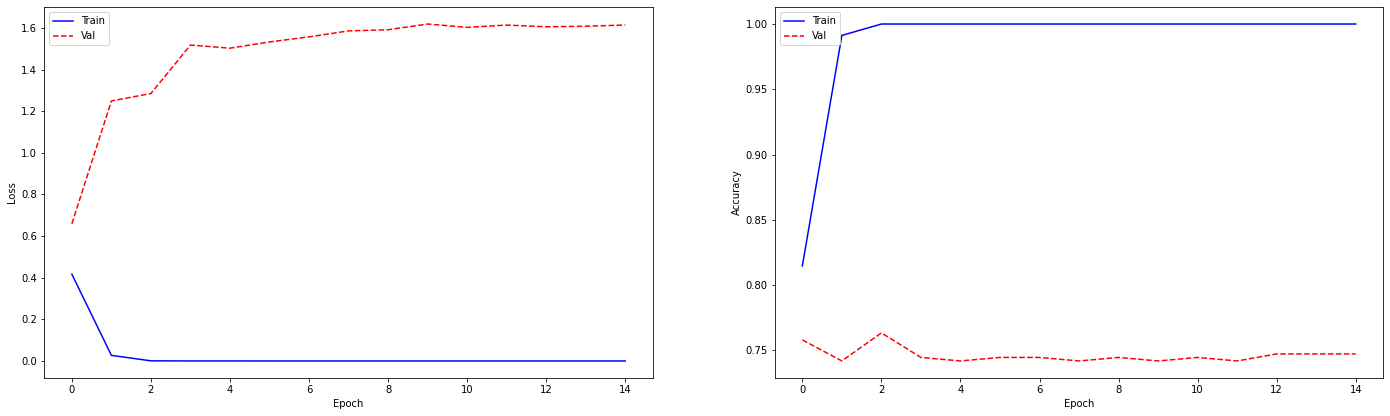

In [ ]:
plot_metrics(nn_model_history)

In [ ]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 3 - Define and Train Models completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 4 - Evaluate and Optimize Models

In [ ]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 4 - Evaluate and Optimize Models has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

## 4.a) Alternate Model One

In [ ]:
# Initialize the neural network model and get the training results for plotting graph
startTimeModule = datetime.now()
reset_random(seedNum)
nn_model_1 = create_nn_model(conv1_filters=256, conv2_filters=128, conv3_filters=64, conv1_dropout=0.25, conv2_dropout=0.25, conv3_dropout=0, dense_nodes=512, dense_dropout=0.25)
nn_model_history = nn_model_1.fit(
    training_generator,
    steps_per_epoch=len(training_generator),
	validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=default_epoch,
    callbacks=[learning_rate_reduction],
    verbose=1)
print('Total time for model fitting:', (datetime.now() - startTimeModule))

Epoch 1/15
158/158 [==============================] - 11s 67ms/step - loss: 0.5752 - accuracy: 0.7667 - val_loss: 0.5331 - val_accuracy: 0.8602
Epoch 2/15
158/158 [==============================] - 10s 64ms/step - loss: 0.0670 - accuracy: 0.9893 - val_loss: 0.3924 - val_accuracy: 0.8737
Epoch 3/15
158/158 [==============================] - 11s 67ms/step - loss: 0.0275 - accuracy: 0.9952 - val_loss: 0.4116 - val_accuracy: 0.8575
Epoch 4/15
158/158 [==============================] - ETA: 0s - loss: 0.0125 - accuracy: 0.9988
Epoch 00004: ReduceLROnPlateau reducing learning rate to 1e-05.
158/158 [==============================] - 10s 66ms/step - loss: 0.0125 - accuracy: 0.9988 - val_loss: 0.3905 - val_accuracy: 0.8629
Epoch 5/15
158/158 [==============================] - 10s 64ms/step - loss: 0.0095 - accuracy: 0.9988 - val_loss: 0.4440 - val_accuracy: 0.8468
Epoch 6/15
158/158 [==============================] - 10s 64ms/step - loss: 0.0065 - accuracy: 0.9992 - val_loss: 0.4269 - val_accu

In [ ]:
nn_model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 150, 150, 256)     7168      
_________________________________________________________________
dropout_4 (Dropout)          (None, 150, 150, 256)     0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 75, 75, 256)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 75, 75, 128)       295040    
_________________________________________________________________
dropout_5 (Dropout)          (None, 75, 75, 128)       0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 38, 38, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 38, 38, 64)       

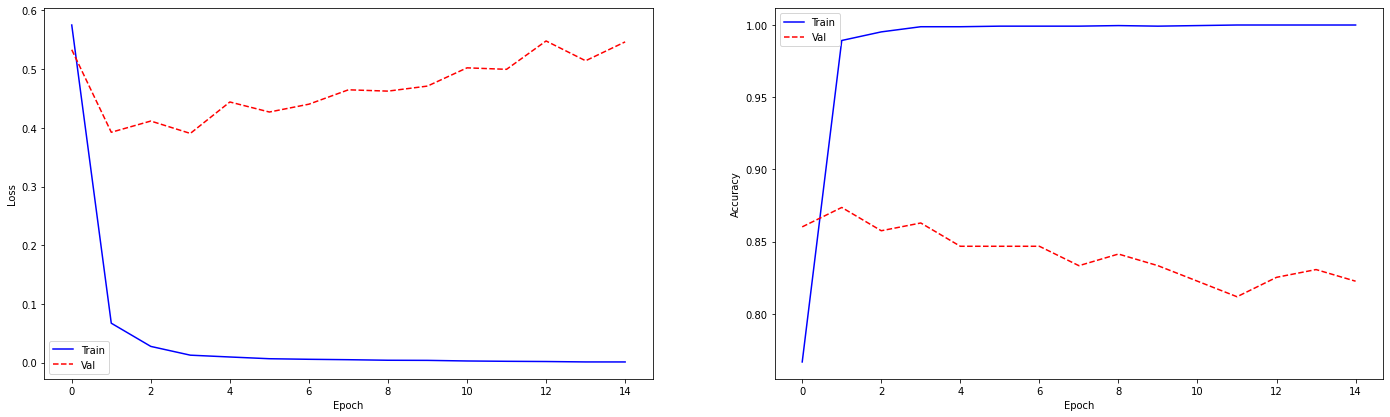

In [ ]:
plot_metrics(nn_model_history)

In [ ]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 4 - Evaluate and Optimize Models completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 5 - Finalize Model and Make Predictions

In [ ]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 5 - Finalize Model and Make Predictions has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [ ]:
final_model = nn_model_1

# Display a summary of the final model
final_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 150, 150, 256)     7168      
_________________________________________________________________
dropout_4 (Dropout)          (None, 150, 150, 256)     0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 75, 75, 256)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 75, 75, 128)       295040    
_________________________________________________________________
dropout_5 (Dropout)          (None, 75, 75, 128)       0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 38, 38, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 38, 38, 64)       

In [ ]:
# Print the labels used for the modeling
print(validation_generator.class_indices)

{'paper': 0, 'rock': 1, 'scissors': 2}


In [ ]:
final_model.evaluate(validation_generator, verbose=1)

24/24 [==============================] - 1s 48ms/step - loss: 0.5465 - accuracy: 0.8226


[0.5464686751365662, 0.8225806355476379]

In [ ]:
test_pred = final_model.predict(validation_generator)
test_predictions = np.argmax(test_pred, axis=-1)
test_original = validation_generator.labels
print('Accuracy Score:', accuracy_score(test_original, test_predictions))
print(confusion_matrix(test_original, test_predictions))
print(classification_report(test_original, test_predictions))

Accuracy Score: 0.8225806451612904
[[121   3   0]
 [ 15 100   9]
 [ 27  12  85]]
              precision    recall  f1-score   support

           0       0.74      0.98      0.84       124
           1       0.87      0.81      0.84       124
           2       0.90      0.69      0.78       124

    accuracy                           0.82       372
   macro avg       0.84      0.82      0.82       372
weighted avg       0.84      0.82      0.82       372



In [ ]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 5 - Finalize Model and Make Predictions completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [ ]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:05:28.906135
